In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import logging
import warnings
from pathlib import Path 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas_profiling as pp 


warnings.filterwarnings('ignore')

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')
# 数据集目录
data_path = Path(r'/Users/liuzhi/datasets/tc_金融风控-贷款违约预测')

In [4]:
train = pd.read_csv(f"{data_path}/train.csv")
testA = pd.read_csv(f"{data_path}/testA.csv")
logging.info(f"train shape: {train.shape}")
logging.info(f"testA shape: {testA.shape}")
train.head()

2021-01-07 22:06:11,500 INFO: train shape: (800000, 47)
2021-01-07 22:06:11,501 INFO: testA shape: (200000, 46)


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


### EDA
1.EDA价值主要在于熟悉了解整个数据集的基本情况（缺失值，异常值），对数据集进行验证是否可以进行接下来的机器学习或者深度学习建模.

2.了解变量间的相互关系、变量与预测值之间的存在关系。

3.为特征工程做准备

In [6]:
# 通过info()来熟悉数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

### 查看数据集中特征缺失值，唯一值等情况
1.纵向了解哪些列存在 “nan”, 并可以把nan的个数打印，主要的目的在于查看某一列nan存在的个数是否真的很大，如果nan存在的过多，说明这一列对label的影响几乎不起作用了，可以考虑删掉。如果缺失值很小一般可以选择填充。

2.另外可以横向比较，如果在数据集中，某些样本数据的大部分列都是缺失的且样本足够的情况下可以考虑删除。

3.比赛大杀器lgb模型可以自动处理缺失值

In [11]:
def get_feature_null_more_than_half(df):
    r'''缺失值超过一半的特征'''
    feature_null_more_than_half = {}
    have_null_feature_dict = (df.isnull().sum()/len(df)).to_dict()
    for k,v in have_null_feature_dict.items():
        if v > 0.5:
            feature_null_more_than_half[k] = v
    return feature_null_more_than_half
    
def get_one_value_featrue(df):
    r'''获取全为空、或只有一个值得列'''
    return [col for col in df.columns if df[col].nunique() <= 1]


def plot_missing(df):
    r'''展示具体缺失值得缺失率'''
    missing = df.isnull().sum()/len(df)
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

2021-01-07 22:48:07,592 INFO: 
缺失值超过一半的特征:
{}



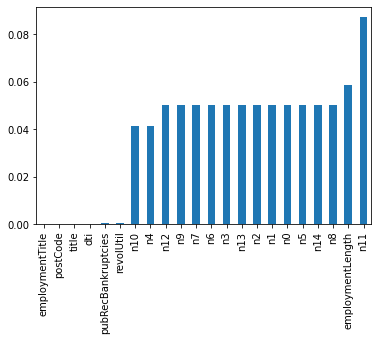

In [19]:
# 缺失值超过一半的特征
logging.info(f"\n缺失值超过一半的特征:\n{get_feature_null_more_than_half(train)}\n")

# 展示具体缺失值得缺失率
plot_missing(train)

In [20]:
# 获取全为空、或只有一个值得列
one_value_featrue = get_one_value_featrue(train)
logging.info(f"\n空值或唯一值的列：{one_value_featrue}\n")

2021-01-07 22:48:25,662 INFO: 
空值或唯一值的列：['policyCode']



### 查看特征的数值类型 / 对象类型

1.特征一般都是由类别型特征和数值型特征组成，而数值型特征又分为连续型和离散型。

2.类别型特征有时具有非数值关系，有时也具有数值关系。比如‘grade’中的等级A，B，C等，是否只是单纯的分类，还是A优于其他要结合业务判断。

3.数值型特征本是可以直接入模的，但往往风控人员要对其做分箱，转化为WOE编码进而做标准评分卡等操作。从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量和因变量的相关度。从而使模型更加稳定。

In [21]:
def split_numerical_and_category_features(df):
    r'''拆分数值列、类别列'''
    numerical_features = list(df.select_dtypes(exclude=['object']).columns)
    category_features = list(filter(lambda x: x not in numerical_features, list(df.columns)))
    return numerical_features, category_features

def split_serial_noserial_of_numerical_features(df, numerical_features, THRESH=10):
    r'''划分数值型变量中的连续变量和离散型变量'''
    numerical_serial_features = []
    numerical_noserial_features = []
    for fea in numerical_features:
        nclasses = df[fea].nunique()
        if nclasses <= THRESH:
            numerical_noserial_features.append(fea)
            continue
        numerical_serial_features.append(fea)
    return numerical_serial_features, numerical_noserial_features

In [18]:
numerical_features, category_features = split_numerical_and_category_features(train)
logging.info(f"\n数值列：\n{numerical_features}\n\n类别列：\n{category_features}\n")

2021-01-07 22:47:45,322 INFO: 
数值列：
['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']

类别列：
['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']



In [22]:
numerical_serial_features, numerical_noserial_features = split_serial_noserial_of_numerical_features(train, numerical_features)
logging.info(f"\n连续变量列：\n{numerical_serial_features}\n\n离散型变量列：\n{numerical_noserial_features}\n")

2021-01-07 22:56:26,522 INFO: 
连续变量列：
['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']

离散型变量列：
['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']



### 数值类别型变量分析

In [36]:
train['term'].value_counts()  # 离散型变量

3    606902
5    193098
Name: term, dtype: int64

In [35]:
train['homeOwnership'].value_counts()  # 离散型变量

0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64

In [34]:
train['verificationStatus'].value_counts()  # 离散型变量

1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64

In [33]:
train['isDefault'].value_counts()  # 离散型变量

0    640390
1    159610
Name: isDefault, dtype: int64

In [32]:
train['initialListStatus'].value_counts()  # 离散型变量

0    466438
1    333562
Name: initialListStatus, dtype: int64

In [31]:
train['applicationType'].value_counts()  # 离散型变量

0    784586
1     15414
Name: applicationType, dtype: int64

In [30]:
train['policyCode'].value_counts()  # 离散型变量，无用，全部一个值

1.0    800000
Name: policyCode, dtype: int64

In [29]:
train['n11'].value_counts()  # 离散型变量，相差悬殊，用不用再分析

0.0    729682
1.0       540
2.0        24
3.0         1
4.0         1
Name: n11, dtype: int64

In [28]:
train['n12'].value_counts()  # 离散型变量，相差悬殊，用不用再分析

0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: n12, dtype: int64

### 数值连续型变量分析